# **Races feature engineering**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pprint import pprint

os.chdir(os.path.dirname(os.getcwd()))      # Move to parent directory


In [3]:
print(os.getcwd())

cyclists_df = pd.read_csv('dataset/cleaned_cyclists.csv')
races_df = pd.read_csv('dataset/cleaned_races.csv')

/Users/francesco/Desktop/unipi/MAGISTRALE/2_ANNO/data_mining/dm-2425


Given that we leave pending the drop of stages with climb total or profile null, we firstly perform that 

In [4]:
initial_rows = len(races_df)
races_df.dropna(subset=['climb_total', 'profile'], inplace=True)
rows_dropped = initial_rows - len(races_df)
print(f"Number of rows dropped: {rows_dropped}")


Number of rows dropped: 180556


Because we decided to perform clustering analysis over single stages, we group by the dataframe by ```_url``` and we take only one row for each stage, with only those values useful for analyze the stages. Before that we compute average age at the startlist to keep also that feature

In [5]:
# Compute the average age for each _url group
average_age = races_df.groupby('_url')['cyclist_age'].mean().reset_index()

# Rename the column to 'average_age'
average_age.rename(columns={'cyclist_age': 'average_age'}, inplace=True)

# Merge the average_age back to the races_df
races_df = races_df.merge(average_age, on='_url', how='left')

# Display the updated dataframe
races_df.drop(columns=['cyclist_age', 'cyclist_team', 'position', 'cyclist'], inplace=True)

In [6]:
races_df = races_df.groupby('_url').first().reset_index()

# Print the remaining columns in the races_df dataframe
print("Remaining columns in the races_df dataframe:")
pprint(races_df.columns.to_list())

Remaining columns in the races_df dataframe:
['_url',
 'name',
 'points',
 'length',
 'climb_total',
 'profile',
 'startlist_quality',
 'is_tarmac',
 'start_date',
 'duration',
 'average_age']


Count how many rows remaining

In [7]:
remaining_rows = len(races_df)
print(f"Number of remaining rows: {remaining_rows}")

Number of remaining rows: 2614


In [8]:
races_df.describe()

,points,length,climb_total,profile,startlist_quality,average_age
count,2614.000000,2614.000000,2614.000000,2614.000000,2614.000000,2614.000000
mean,89.850803,166532.999235,2388.298011,2.664116,1175.598699,28.657916
std,46.032991,61207.946373,1395.058276,1.509391,389.668771,0.742413
min,20.000000,1000.000000,2.000000,1.000000,156.000000,26.460870
25%,80.000000,152225.000000,1353.250000,1.000000,885.000000,28.321233
50%,80.000000,178000.000000,2308.000000,2.000000,1044.500000,28.736098
75%,100.000000,202000.000000,3363.000000,4.000000,1520.000000,29.133203
max,350.000000,338000.000000,6974.000000,5.000000,2047.000000,30.204678


#### ```difficulty_idx``` column


In [9]:
from utils import compute_difficulty_index

races_df['difficulty_idx'] = races_df.apply(
        lambda row: compute_difficulty_index(row['length']/1000, row['climb_total']/1000, row['profile']),
        axis=1
        )

In [10]:
print(f"Null values in avg_slope column: {int(races_df['difficulty_idx'].isnull().sum())}")

Null values in avg_slope column: 0


In [11]:
races_df["difficulty_idx"].describe()

count    2614.000000
mean       51.659189
std        18.828579
min         0.430000
25%        47.387500
50%        55.405000
75%        62.470000
max       102.710000
Name: difficulty_idx, dtype: float64

Normalize this difficulty index

In [12]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the 'difficulty_index' column
races_df['difficulty_index_normalized'] = scaler.fit_transform(races_df[['difficulty_idx']]).round(2)
races_df.drop(columns=['difficulty_idx'], inplace=True)
races_df.rename(columns={'difficulty_index_normalized': 'difficulty_idx'}, inplace=True)

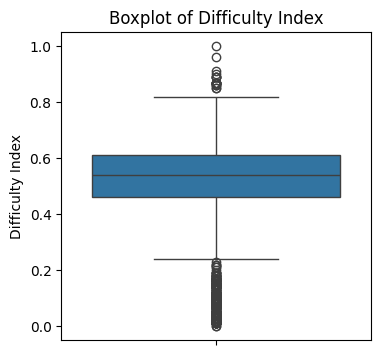

In [13]:
plt.figure(figsize=(4, 4))
sns.boxplot(y='difficulty_idx', data=races_df)
plt.title('Boxplot of Difficulty Index')
plt.ylabel('Difficulty Index')
plt.show()

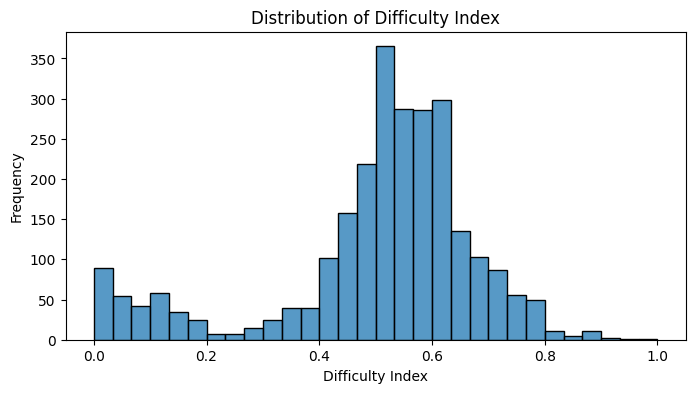

In [14]:
# Plot the distribution of the difficulty index
plt.figure(figsize=(8, 4))
sns.histplot(races_df['difficulty_idx'], bins=30)
plt.title('Distribution of Difficulty Index')
plt.xlabel('Difficulty Index')
plt.ylabel('Frequency')
plt.show()

### ```season``` column 

In [15]:
from utils import get_season

# Apply the custom get_season function to create a new column 'season'
races_df['season'] = races_df['start_date'].apply(lambda x: get_season(pd.to_datetime(x)))

# Display the first few rows to verify
print(races_df[['start_date', 'season']].head(5))

   start_date  season
0  2012-04-15  Spring
1  2013-04-14  Spring
2  2014-04-20  Spring
3  2015-04-19  Spring
4  2016-04-17  Spring


### ```avg_slope``` column

Average slope of the stage can be useful as another indicator of stage complexity. We expect that the higher the slope the more complex is the race. 

In [16]:
# Calculate the average slope and create the new column
races_df['avg_slope'] = ((races_df['climb_total'] / races_df['length'])*100).round(4)

# Display the first few rows to verify
print(races_df[['climb_total', 'length', 'avg_slope']].head(10))

   climb_total    length  avg_slope
0       3300.0  256500.0     1.2865
1       3500.0  251800.0     1.3900
2       3495.0  251400.0     1.3902
3       3558.0  258000.0     1.3791
4       3320.0  248700.0     1.3349
5       3328.0  261000.0     1.2751
6       3496.0  263000.0     1.3293
7       3536.0  265700.0     1.3308
8       2893.0  218600.0     1.3234
9       3460.0  254100.0     1.3617


In [17]:
print(f"Null values in avg_slope column: {int(races_df['avg_slope'].isnull().sum())}")

Null values in avg_slope column: 0


In [18]:
races_df['avg_slope'].describe()

count    2614.000000
mean        1.491999
std         0.904758
min         0.006900
25%         0.884725
50%         1.347350
75%         1.900875
max        10.326100
Name: avg_slope, dtype: float64

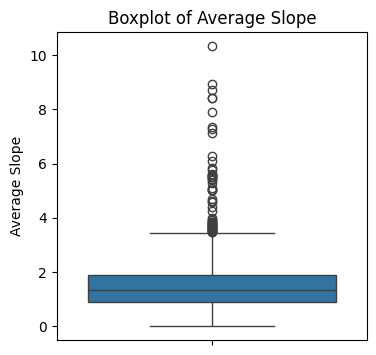

In [19]:
plt.figure(figsize=(4, 4))
sns.boxplot(y='avg_slope', data=races_df)
plt.title('Boxplot of Average Slope')
plt.ylabel('Average Slope')
plt.show()

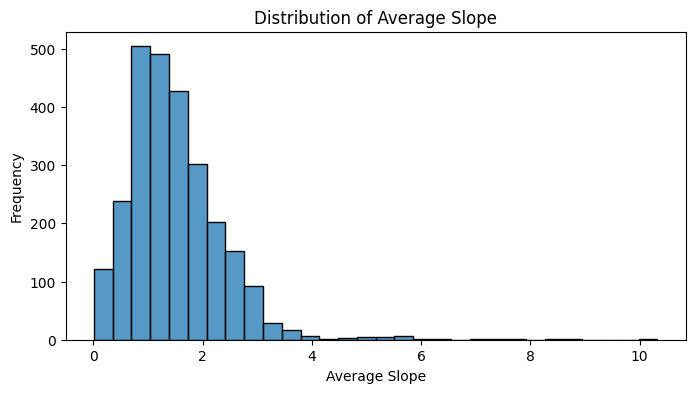

In [20]:
# Plot the distribution of the average slope
plt.figure(figsize=(8, 4))
sns.histplot(races_df['avg_slope'], bins=30)
plt.title('Distribution of Average Slope')
plt.xlabel('Average Slope')
plt.ylabel('Frequency')
plt.show()

### ```min_duration``` column 

We decided to drop the ```delta``` column and the ```duration``` column as they contain many errors and as in the final clustering we will try to cluster stages and riders rather than riders and stages together. For this reason, we create a new feature min_duration that contains the total time taken for the first cyclist to finish the stage, as this could be another measure to assess the difficulty of the stage.

In [21]:
# Group by '_url' and take the first entry in 'duration' for each group
races_df['min_duration'] = races_df.groupby('_url')['duration'].transform('first')

# Display the first few rows to verify
print(races_df[['duration', 'min_duration']].head(7))

# Convert 'min_duration' to total seconds
races_df['min_duration'] = races_df['min_duration'].apply(lambda x: int(pd.to_timedelta(str(x)).total_seconds()))

# Display the first few rows to verify
print(races_df[['min_duration']].head(7))

   duration min_duration
0  06:32:35     06:32:35
1  06:35:21     06:35:21
2  06:25:57     06:25:57
3  06:31:49     06:31:49
4  06:18:03     06:18:03
5  06:31:40     06:31:40
6  06:35:07     06:35:07
   min_duration
0         23555
1         23721
2         23157
3         23509
4         22683
5         23500
6         23707


In [22]:
races_df['min_duration'].describe()

count     2614.000000
mean     15145.942234
std       5883.172192
min         74.000000
25%      13332.250000
50%      15981.000000
75%      18501.750000
max      34811.000000
Name: min_duration, dtype: float64

In [23]:
grouped_df = races_df.groupby('min_duration')[['length', '_url']].value_counts().sort_index()
print(grouped_df)

min_duration  length    _url                          
74            1000.0    tour-de-france/1988/prologue      1
80            1150.0    giro-d-italia/2005/prologue       1
209           3340.0    tour-de-romandie/2012/prologue    1
217           2900.0    paris-nice/2013/prologue          1
306           3870.0    tour-de-romandie/2019/prologue    1
                                                         ..
28717         282000.0  tour-de-france/1980/stage-3       1
29002         236500.0  tour-de-france/1980/stage-5       1
30331         269000.0  tour-de-france/1985/stage-12      1
34088         320500.0  tour-de-france/1984/stage-21      1
34811         338000.0  tour-de-france/1984/stage-9       1
Name: count, Length: 2614, dtype: int64


---

### Scatter Plot

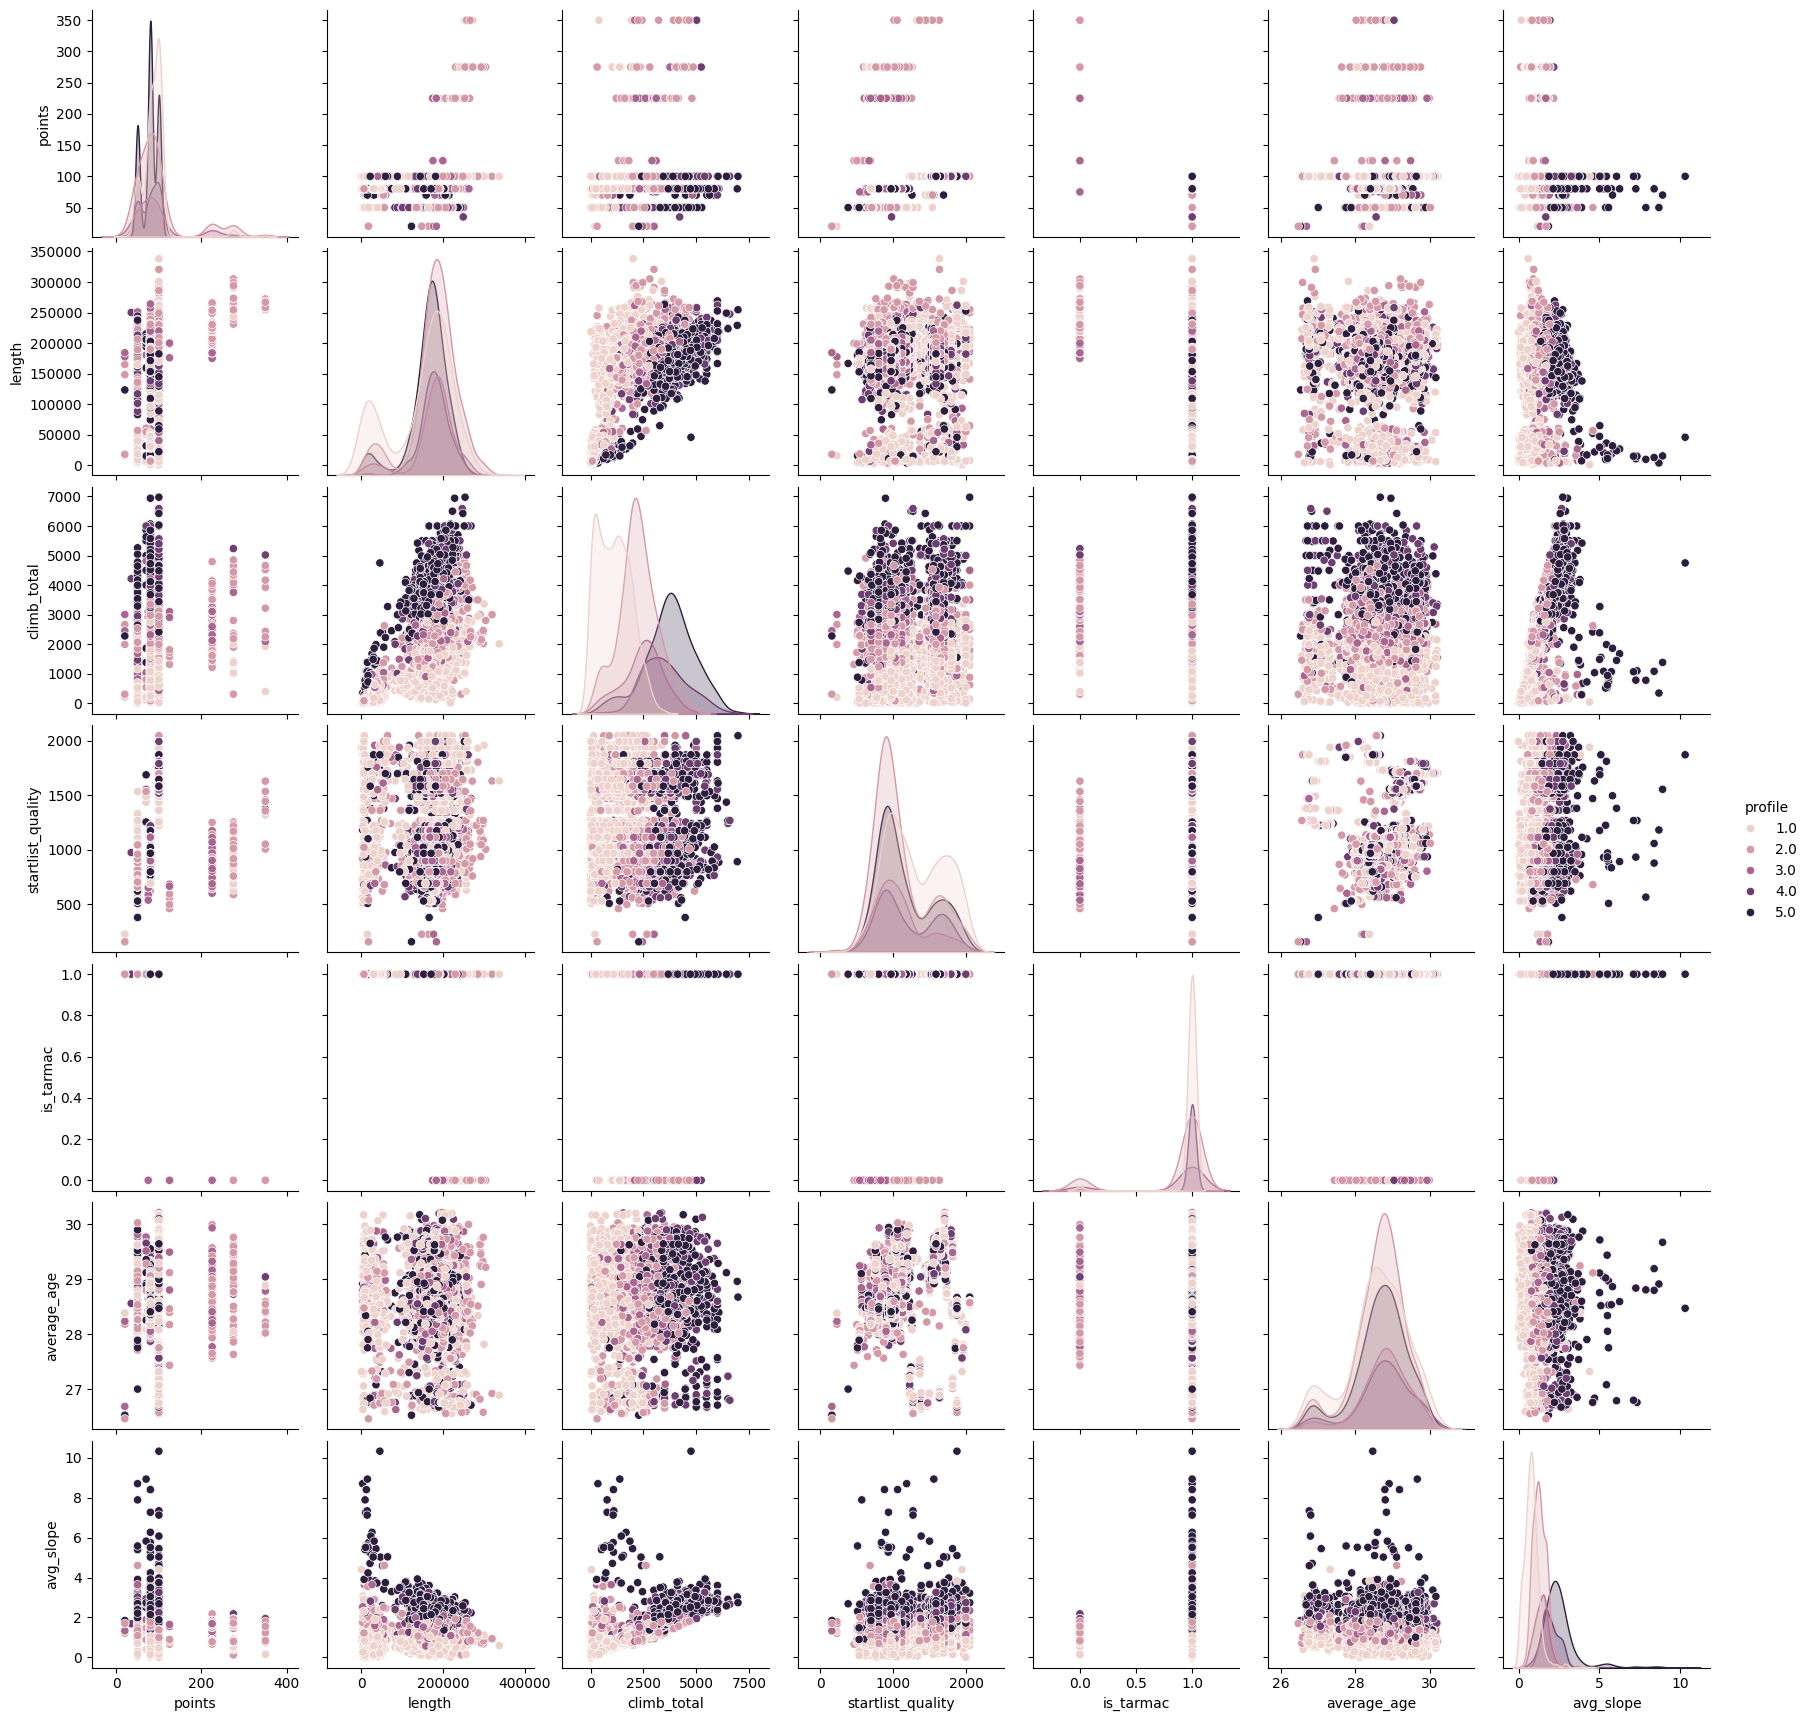

In [33]:
sns.pairplot(races_df, hue='profile')
plt.show()

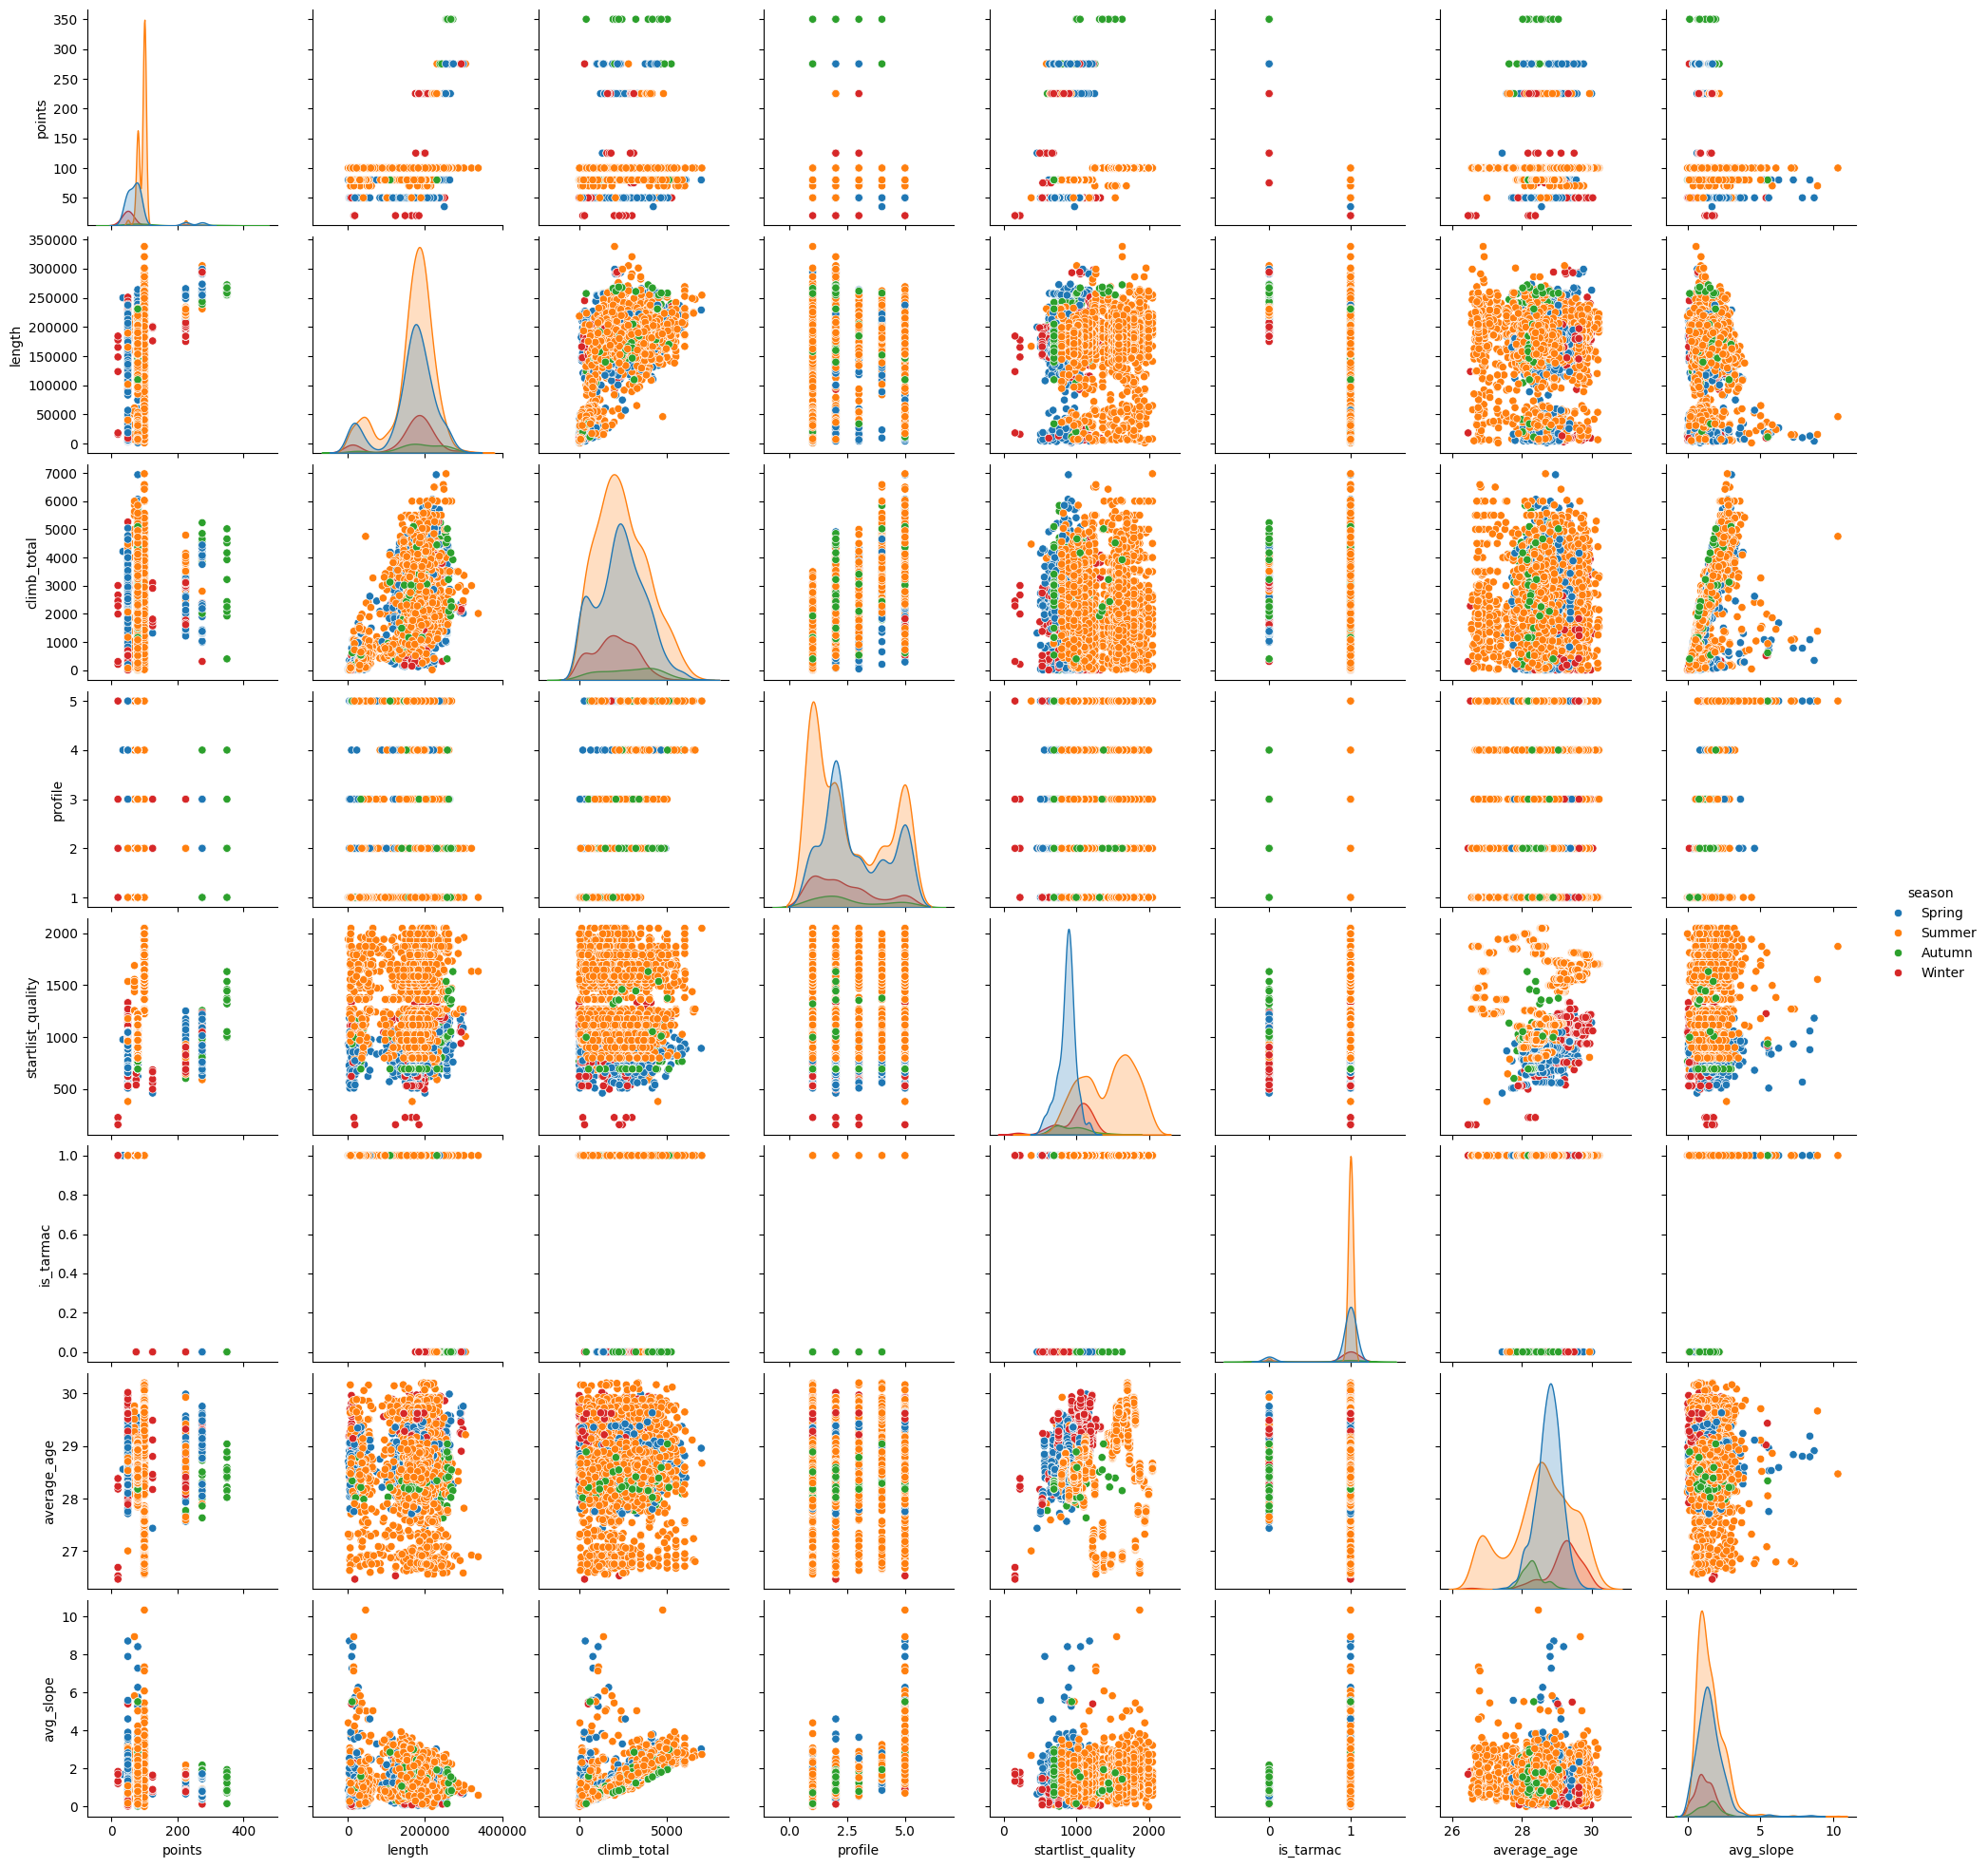

In [34]:
sns.pairplot(races_df, hue='season')
plt.show()

---

### Correlation Analysis

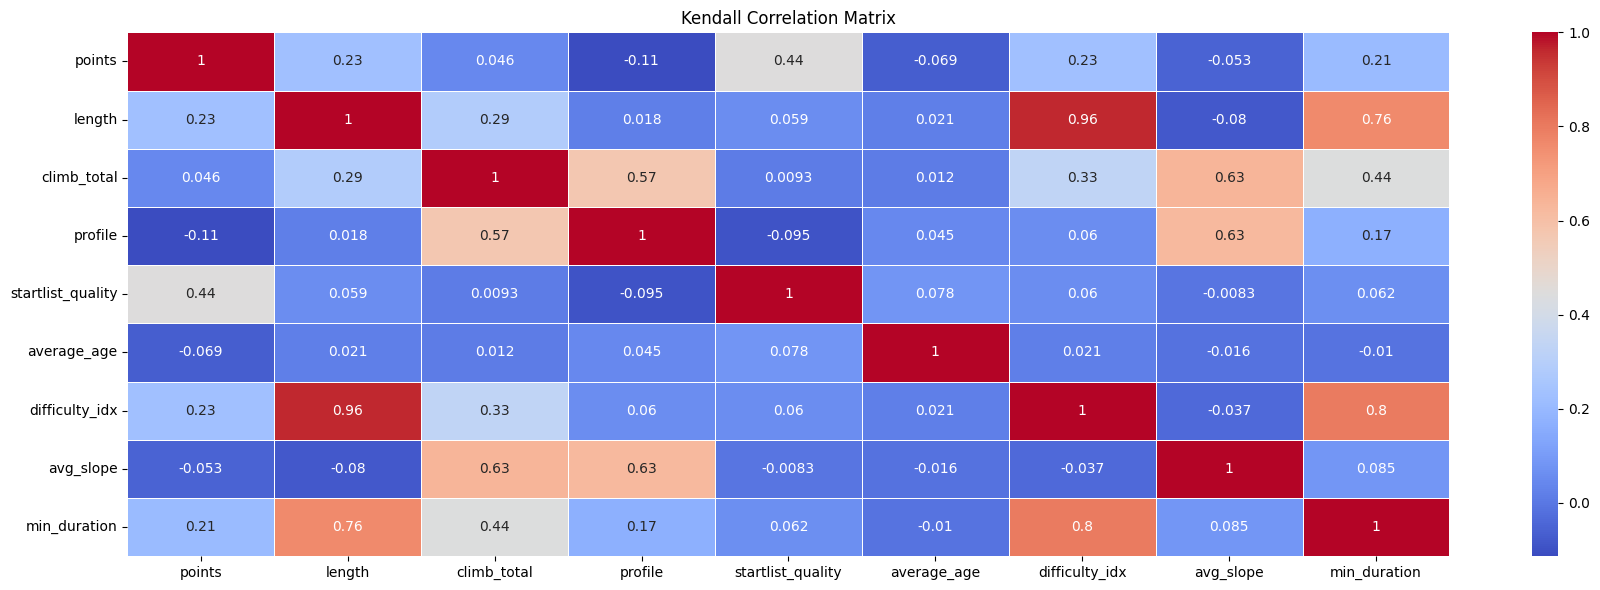

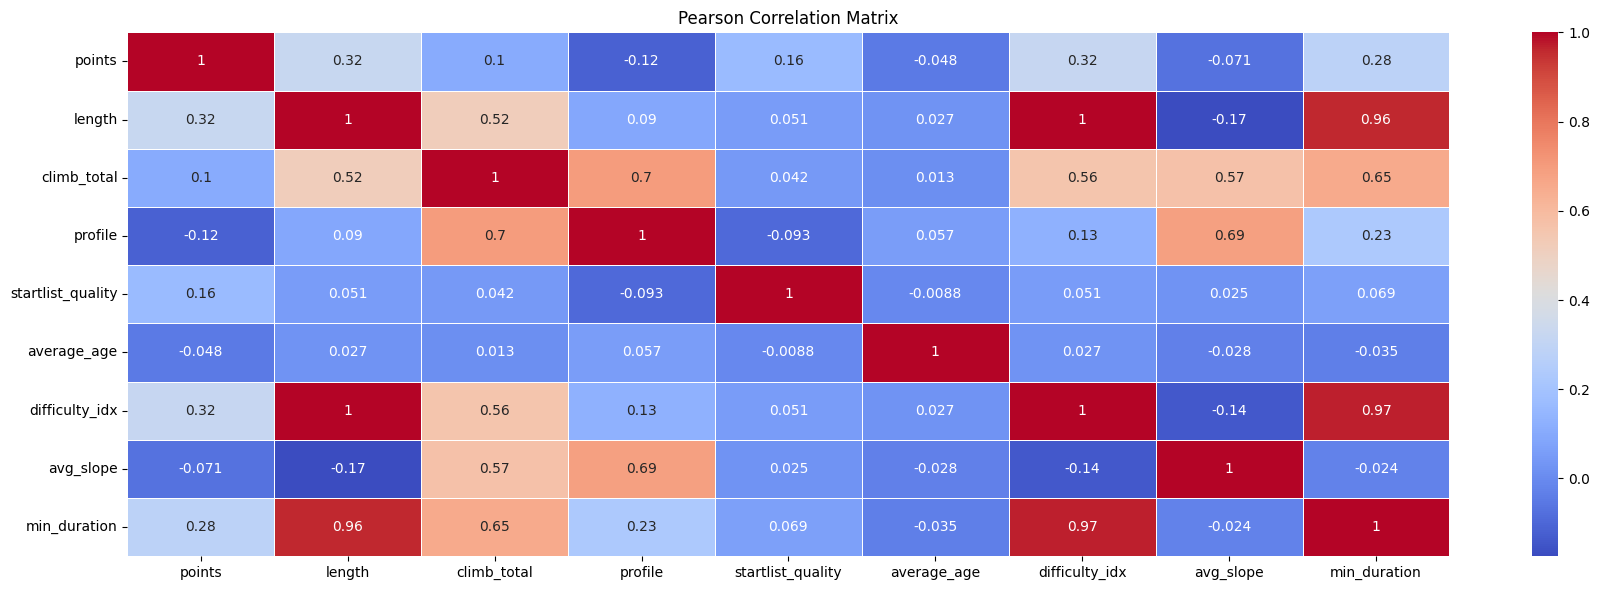

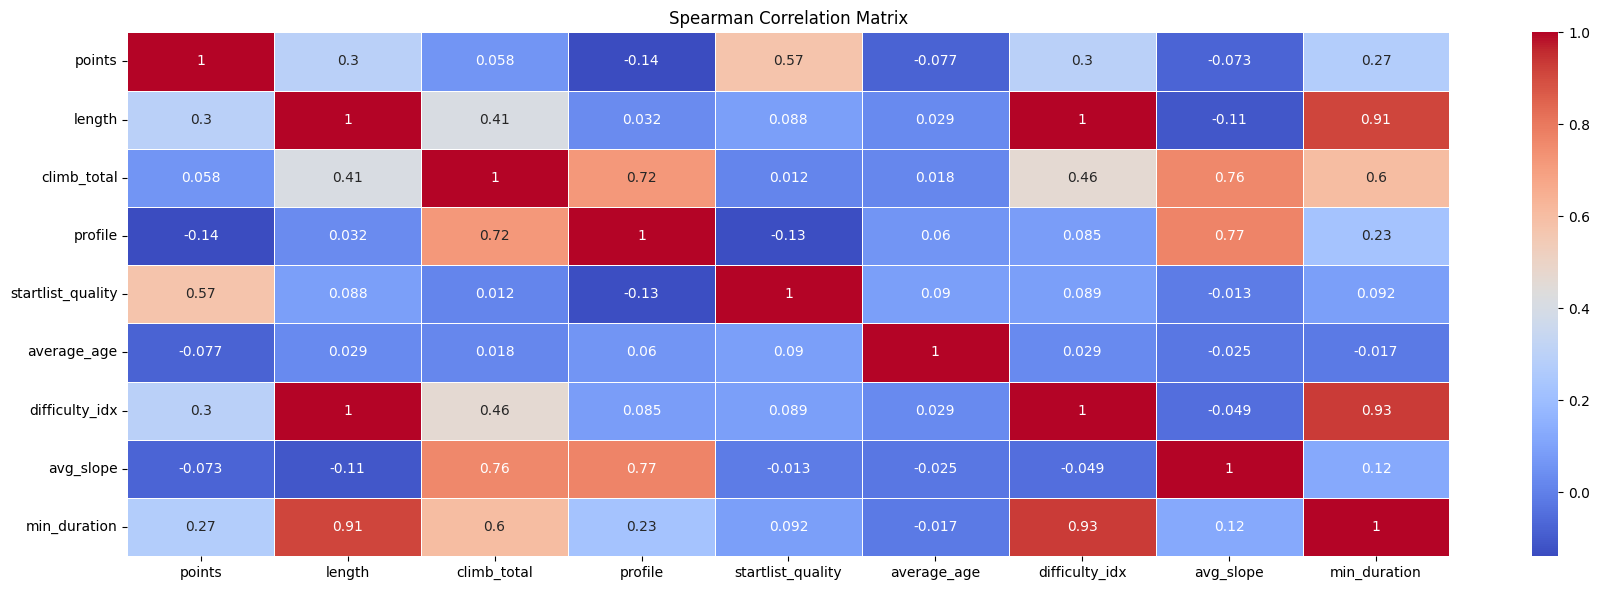

In [24]:
from utils import center_and_scale, correlations, plot_correlations

normalized_races, normalization_scalers_races = center_and_scale(races_df)
cyclists_corr = correlations(normalized_races, ["kendall"])
plot_correlations(cyclists_corr)
cyclists_corr = correlations(normalized_races, ["pearson"])
plot_correlations(cyclists_corr)
cyclists_corr = correlations(normalized_races, ["spearman"])
plot_correlations(cyclists_corr)

We decide to drop column with high correlation

In [25]:
races_df.drop(columns=['difficulty_idx', 'min_duration'], inplace=True)

Remaining Columns

In [26]:
races_df.columns.to_list()

['_url',
 'name',
 'points',
 'length',
 'climb_total',
 'profile',
 'startlist_quality',
 'is_tarmac',
 'start_date',
 'duration',
 'average_age',
 'season',
 'avg_slope']

In [29]:
# Count and print the number of remaining rows with a nice comment
remaining_rows = len(races_df)
print(f" Number of remaining rows: {remaining_rows}")

 Number of remaining rows: 2614


In [ ]:
cyclists_df.to_csv('dataset/races_clustering.csv', index=False)